# Send emails to remind student to submit their applications after avg. submit time with ND, and 1 day before deadline approaches

## is sending reminder email increase apps submit rate?
* more students submit their apps after received the email
* students submit their apps faster than students do not receive the email

* hold off : 5%

In [1]:
# read data from Laurel
import psycopg2
import pandas as pd
import seaborn as sns
import pymc3 as pm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## We have 2 experiments : 
* apps reaching avg. time students take to submit apps
* apps reaching deadline: 2 days before application close

### First, let's analyze the reaching avg. test.
* How do I calculate the avg. app submit time? We look at all the historical submitted apps for each ND, find out days averagely took a student to submit. If the avg. tims is less than 1 day, we force it to be at least 1 day; If there's a new ND comes up, we force the avg. to be 2 days.

In [2]:
conn_laurel = psycopg2.connect("dbname='analytics' user='analytics' host='analytics.cv90snkxh2gd.us-west-2.rds.amazonaws.com' password='!TgP$Ol9Z&6QhKW0tmn9mOW5rYT2J8'")
sql = "select a.*,case when a.group_indicator <= 95 then 1 else 0 end as send_email\
           ,b.submitted_at,case when b.submitted_at is not null then 1 else 0 end as submit_apps\
           ,submitted_at::date-run_date as delta\
       from admissions.email_campaign_reaching_avg_archive a\
       left join applications b on a.application_id = b.id"
df = pd.read_sql(sql,conn_laurel)

In [3]:
df.groupby(['run_date'])['application_id'].count()

run_date
2017-10-27      24
2017-10-28    1819
2017-10-29    1011
2017-10-30     751
2017-10-31     205
2017-11-01    2309
2017-11-02    2019
2017-11-03     347
2017-11-04     349
2017-11-05     301
2017-11-06     315
2017-11-07     369
2017-11-08     354
2017-11-09     318
2017-11-10     290
2017-11-11     220
2017-11-12     289
2017-11-13     291
2017-11-14     286
2017-11-15     340
2017-11-16     388
2017-11-17     335
Name: application_id, dtype: int64

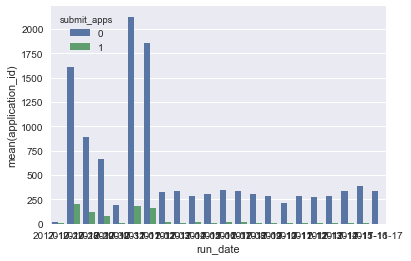

In [4]:
sns.barplot(x='run_date',y='application_id',hue='submit_apps'
            ,data=df.groupby(['run_date','submit_apps'])['application_id'].count().reset_index())

In [5]:
df.groupby(['run_date','send_email','submit_apps'])['application_id'].count()

run_date    send_email  submit_apps
2017-10-27  0           0                 2
            1           0                19
                        1                 3
2017-10-28  0           0                66
                        1                 7
            1           0              1547
                        1               199
2017-10-29  0           0                36
                        1                 5
            1           0               854
                        1               116
2017-10-30  0           0                31
            1           0               637
                        1                83
2017-10-31  0           0                 9
            1           0               184
                        1                12
2017-11-01  0           0                89
                        1                 5
            1           0              2037
                        1               178
2017-11-02  0           0               

### With term, connect and scholarship together, all NDs

In [6]:
n1 = df.loc[df['send_email']==0].shape[0]
obs_v1 = df.loc[(df['send_email']==0) & (df['submit_apps']==1)].shape[0]

n2 = df.loc[df['send_email']==1].shape[0]
obs_v2 = df.loc[(df['send_email']==1) & (df['submit_apps']==1)].shape[0]

print("{0} students received reminder emails, {1} of them submit their apps. ({2})".format(n2,obs_v2,obs_v2/n2))
print("{0} students don't received reminder emails, {1} of them submit their apps. ({2})".format(n1,obs_v1,obs_v1/n1))

12389 students received reminder emails, 914 of them submit their apps. (0.07377512309306643)
541 students don't received reminder emails, 24 of them submit their apps. (0.04436229205175601)


In [7]:
m = (obs_v1+obs_v2)/(n1+n2)
sd = (obs_v1+obs_v2)/(n1+n2)*(1-(obs_v1+obs_v2)/(n1+n2))/(n1+n2)
print("Pool mean: {0}; Pool variance: {1}".format(m,sd))

Pool mean: 0.0725444702242846; Pool variance: 5.203539834815351e-06


In [8]:
m1 = obs_v1/n1
m2 = obs_v2/n2
sd1 = obs_v1/n1*(1-obs_v1/n1)/n1
sd2 = obs_v2/n2*(1-obs_v2/n2)/n2
print("Students received emails: mean is {0} and variance is {1}".format(m2,sd2))
print("Students don't receive emails: mean is {0} and variance is {1}".format(m1,sd1))

Students received emails: mean is 0.07377512309306643 and variance is 5.515566575645275e-06
Students don't receive emails: mean is 0.04436229205175601 and variance is 7.836280794024161e-05


In [9]:
# 95% CI:
g1_lower = m1-1.96*np.sqrt(sd1/n1)
g1_upper = m1+1.96*np.sqrt(sd1/n1)
g2_lower = m2-1.96*np.sqrt(sd2/n2)
g2_upper = m2+1.96*np.sqrt(sd2/n2)
print("for student received emails, 95% of CI conversion rate: [{0},{1}]".format(g2_lower,g2_upper))
print("for student don't receive emails, 95% of CI conversion rate: [{0},{1}]".format(g1_lower,g1_upper))

for student received emails, 95% of CI conversion rate: [0.07373376761834871,0.07381647856778414]
for student don't receive emails, 95% of CI conversion rate: [0.04361633738797768,0.04510824671553433]


## let's do a z-test!

In [10]:
s = m*(1-m)*(1/n1+1/n2)
z = (m2-m1)/np.sqrt(s)
zscore = stats.norm.ppf(.95)
print("z stats is {0}; 90% z score is {1}".format(z,zscore))

z stats is 2.5816990833100135; 90% z score is 1.6448536269514722


## let's do a t-test!

In [11]:
s_t = np.sqrt(((n1-1)*n1*sd1+(n2-1)*n2*sd2)/(n1+n2-2))
t = (m2-m1)/(s_t*np.sqrt(1/n1+1/n2))
tscore = stats.t.ppf(.95,n1+n2-2)
print("t stats is {0}; 90% t score is {1}".format(t,tscore))

t stats is 2.582329450517322; 90% t score is 1.6449715012559483


## If we do a linear regression to check the p-value of coef. of send_email, result should be the same.

In [12]:
# ols
ols = smf.ols('submit_apps~send_email',data=df).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            submit_apps   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.668
Date:                Fri, 17 Nov 2017   Prob (F-statistic):            0.00983
Time:                        09:56:02   Log-Likelihood:                -895.37
No. Observations:               12930   AIC:                             1795.
Df Residuals:                   12928   BIC:                             1810.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0444      0.011      3.979      0.000       0.023       0.066
send_email     0.0294      0.011      2.582      0.010       0.007       0.052
==============================================================================
Omnibus:                     8466.525   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65593.156
Skew:                           3.293   Prob(JB):                         0.00
Kurtosis:                      11.853   Cond. No.                         9.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
X = df['send_email']
X = sm.add_constant(X)

sm.OLS(df['submit_apps'],X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            submit_apps   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.668
Date:                Fri, 17 Nov 2017   Prob (F-statistic):            0.00983
Time:                        09:56:10   Log-Likelihood:                -895.37
No. Observations:               12930   AIC:                             1795.
Df Residuals:                   12928   BIC:                             1810.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0444      0.011      3.979      0.000       0.023       0.066
send_email     0.0294      0.011      2.582      0.010       0.007       0.052
==============================================================================
Omnibus:                     8466.525   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65593.156
Skew:                           3.293   Prob(JB):                         0.00
Kurtosis:                      11.853   Cond. No.                         9.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### One thing good about linear regression is that we can flexibly add more features to see if they are sig. contributing to our target : submit_app.
### Added: 
* application_type: term/connect/scholarship
* ND

#### Application_type impacting?

In [14]:
application_type = pd.get_dummies(df['application_type'])

X = pd.concat([df['send_email'],application_type],axis=1)
X = sm.add_constant(X)

sm.OLS(df['submit_apps'],X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            submit_apps   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     65.88
Date:                Fri, 17 Nov 2017   Prob (F-statistic):           2.88e-42
Time:                        09:56:15   Log-Likelihood:                -800.61
No. Observations:               12930   AIC:                             1609.
Df Residuals:                   12926   BIC:                             1639.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0317      0.012      2.661      0.008       0.008       0.055
send_email      0.0287      0.011      2.532      0.011       0.006       0.051
connect         0.0091      0.028      0.328      0.743      -0.045       0.063
scholarship     0.0427      0.010      4.222      0.000       0.023       0.063
term           -0.0201      0.010     -1.981      0.048      -0.040      -0.000
==============================================================================
Omnibus:                     8293.949   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61983.162
Skew:                           3.219   Prob(JB):                         0.00
Kurtosis:                      11.579   Cond. No.                     1.08e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.71e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### ND impacting?

In [15]:
smf.ols('submit_apps~send_email+C(nd_key)',data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            submit_apps   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     28.81
Date:                Fri, 17 Nov 2017   Prob (F-statistic):           1.06e-39
Time:                        09:56:24   Log-Likelihood:                -798.58
No. Observations:               12930   AIC:                             1613.
Df Residuals:                   12922   BIC:                             1673.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0743      0.011      6.560      0.000       0.052       0.096
C(nd_key)[T.nd002-connect]    -0.0195      0.072     -0.273      0.785      -0.160       0.121
C(nd_key)[T.nd009-connect]    -0.0184      0.051     -0.364      0.716      -0.118       0.081
C(nd_key)[T.nd013]            -0.0584      0.007     -8.533      0.000      -0.072      -0.045
C(nd_key)[T.nd209]            -0.0756      0.008     -9.021      0.000      -0.092      -0.059
C(nd_key)[T.nd803-connect]    -0.0916      0.082     -1.122      0.262      -0.251       0.068
C(nd_key)[T.nd889]            -0.0609      0.006    -10.970      0.000      -0.072      -0.050
send_email                     0.0288      0.011      2.540      0.011       0.007       0.051
==============================================================================
Omnibus:                     8289.314   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61877.608
Skew:                           3.217   Prob(JB):                         0.00
Kurtosis:                      11.571   Cond. No.                         51.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### From the result above, we can see that:
* In general, the impact of sending email to drive app submission is: term > scholarship > connect.
* If we look at specific ND closely, same result found as above.

## let's do a bayesian ab testing!

### use beta distribution for priors and bernoulli distribution for likelihood


### P(RateOfSucess|Success) = Beta(a,b)

* a: number of times success observed
* b: number of times failure observed
* This distribution tells us which rates of success are most likely given the data we have.

* In Bayesian terms, estimates of the true rate of success given observed data is referred to as the Likelihood.

### Posterior = Likelihood\*Prior


### how to decide prior?
* if your data are arrays, plot to find distribution (e.g. grades of students in diff classes)
* in our case, we have 2 conversion rate to compare, try Beta

### is prior_v1 = prior_v2 all time?
* No. depends on your preference on your priors. how strong belief you have in your data.
* in our case, our hold-off group is 5%, means we have a strong bias sending emails will improve conversion rate.

to simply question, we set the priors the same in two groups: Beta(1.4,34). reason to pick a = 1.4 and b = 34 is due to mean and variance of p above. (mean is somewhere 0.05)

In [16]:
with pm.Model() as model: # context management
    # define priors
    prior_v1 = pm.Beta('prior_v1', alpha=1.4, beta=34)
    prior_v2 = pm.Beta('prior_v2', alpha=1.4, beta=34)
    #prior_v1 = pm.Normal('prior_v1', mu=m1, sd=sd1)
    #prior_v2 = pm.Normal('prior_v2', mu=m2, sd=sd2)

    # define likelihood
    like_v1 = pm.Binomial('like_v1', n=n1, p=prior_v1, observed=obs_v1)
    like_v2 = pm.Binomial('like_v2', n=n2, p=prior_v2, observed=obs_v2)
    
    ## define metrics
    pm.Deterministic('difference', prior_v2 - prior_v1)
    pm.Deterministic('relation', (prior_v2/prior_v1) - 1)
    
    # inference
    trace = pm.sample(draws=50000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)

logp = -2.9406, ||grad|| = 0.0030626: 100%|██████████| 14/14 [00:00<00:00, 1682.24it/s]  
100%|██████████| 50500/50500 [00:10<00:00, 4657.54it/s]


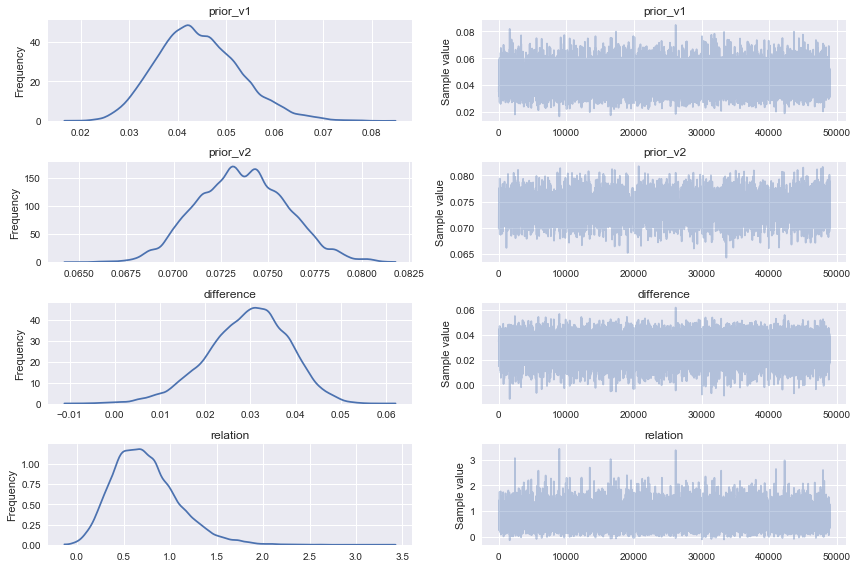

In [17]:
_ = pm.traceplot(trace[1000:], grid=True)

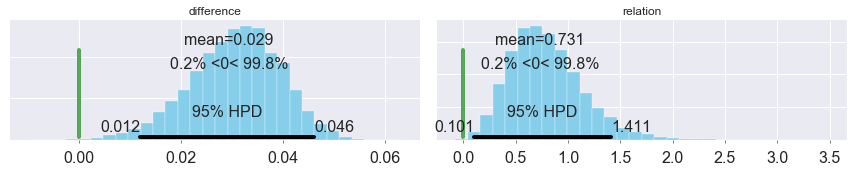

In [18]:
_ = pm.plot_posterior(trace[1000:], varnames=['difference', 'relation'], 
                      ref_val=0, color='#87ceeb')

### baysian in ols
* set likelihood to be Bernoulli. in order to make sure the model output is between 0 and 1, prior of intercept and x_coef are set uniform within a very small range.

In [18]:
with pm.Model() as model_b:
    #priors
    intercept = pm.Uniform('Intercept',lower=0,upper=0.1)
    x_coef = pm.Uniform('x',lower=0.0001,upper=0.1)
    #sigma = pm.HalfCauchy('sigma',beta=10,testval=1.0)
    
    #likelihood
    likelihood = pm.Bernoulli('y',p=intercept+x_coef*df['send_email'],observed=df['submit_apps'])
    
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [00:39<00:00, 268.54it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x122923f98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x121f8a860>], dtype=object)

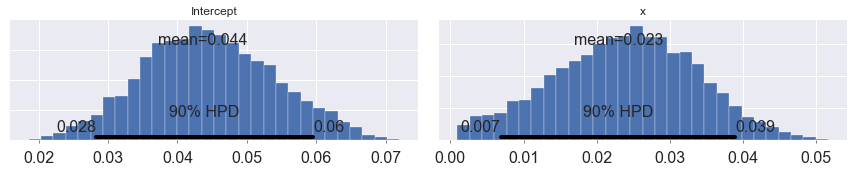

In [19]:
pm.plot_posterior(trace,alpha_level=0.1)

### baysian in ols 2
* instead of uniform distribution. since we know that the conversion rate is around 5%, let's just set intercept to be a very strict uniform distribution of U(0.04,0.06).

In [20]:
with pm.Model() as model_b:
    #priors
    #intercept = pm.Normal('Intercept',mu=0.05,sd=1e-10)
    intercept = pm.Uniform('Intercept',lower=0.04,upper=0.06)
    x_coef = pm.Uniform('x',lower=-0.04,upper=0.9)
    #sigma = pm.HalfCauchy('sigma',beta=10,testval=1.0)
    
    #likelihood
    likelihood = pm.Bernoulli('y',p=intercept+x_coef*df['send_email'],observed=df['submit_apps'])
    
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [00:30<00:00, 349.22it/s]


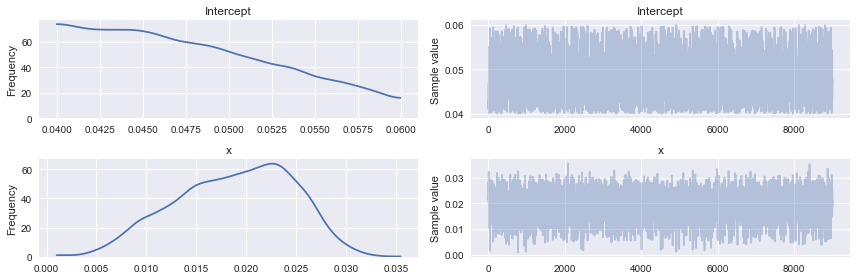

In [21]:
_ = pm.traceplot(trace[1000:], grid=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1227a8f98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x122f68e80>], dtype=object)

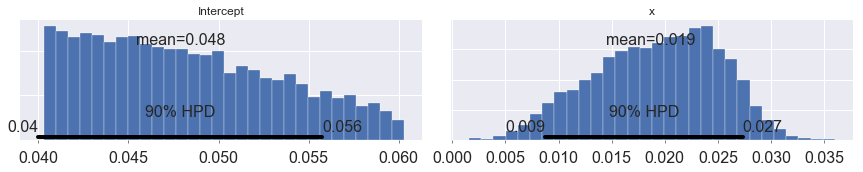

In [22]:
pm.plot_posterior(trace,alpha_level=0.1)

### bayesian: logistics regression

In [31]:
with pm.Model() as model_glm:
    #family = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula('submit_apps~send_email',df,family=pm.glm.families.Binomial())
    trace=pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 10496/10500 [02:04<00:00, 84.55it/s]/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.883311182468, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 10500/10500 [02:04<00:00, 84.57it/s]


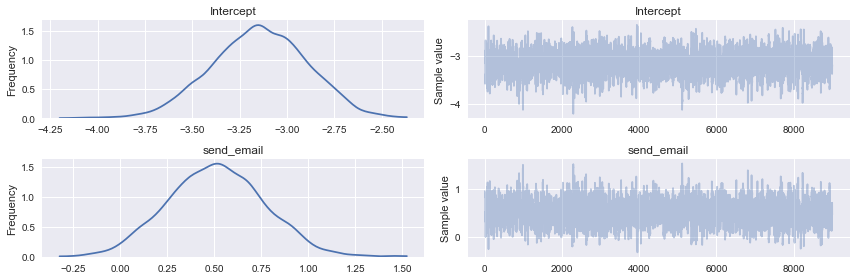

In [32]:
_ = pm.traceplot(trace[1000:], grid=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x122874780>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x122f6cd68>], dtype=object)

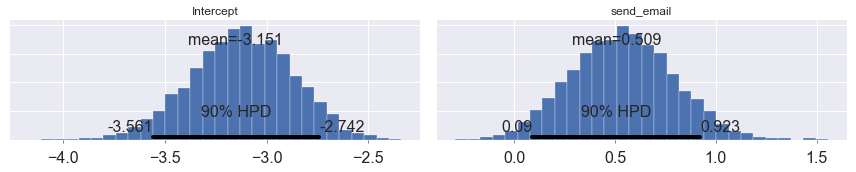

In [33]:
pm.plot_posterior(trace,alpha_level=0.1)

### bayesian: logistics regression with application_type

In [34]:
with pm.Model() as model_glm_2:
    #family = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula('submit_apps~send_email+C(application_type)',df,family=pm.glm.families.Binomial())
    trace=pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 10499/10500 [08:03<00:00, 21.70it/s]/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.909131178654, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 10500/10500 [08:03<00:00, 21.70it/s]


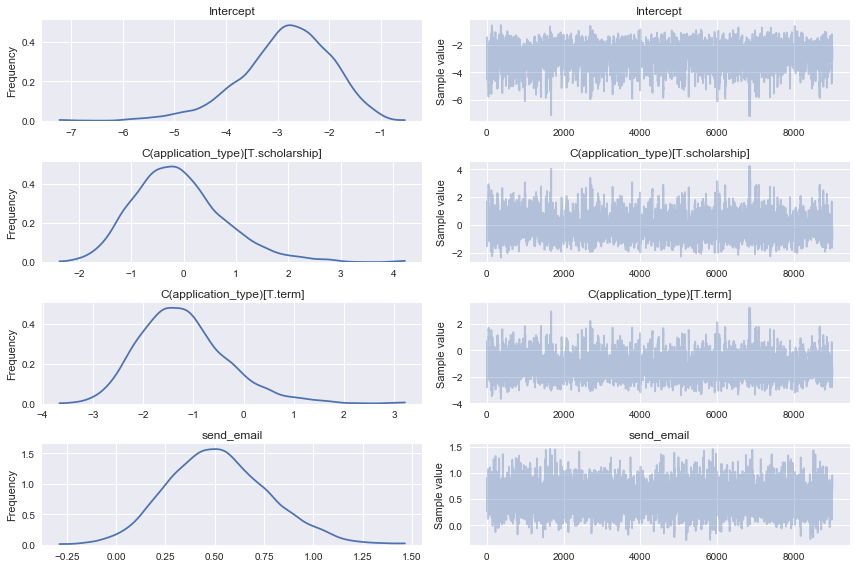

In [35]:
_ = pm.traceplot(trace[1000:], grid=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x123fc7780>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x125838f98>], dtype=object)

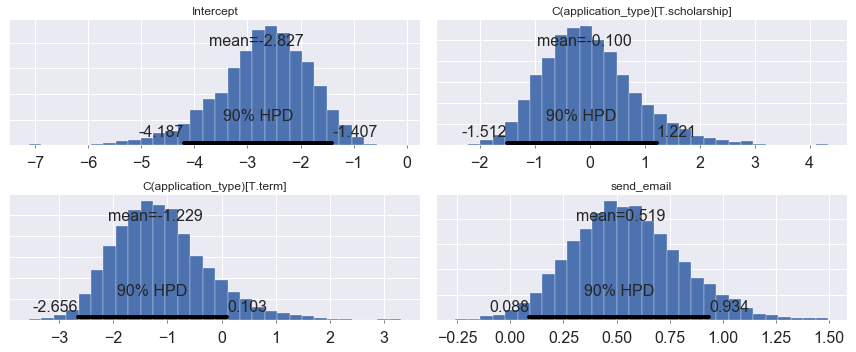

In [36]:
pm.plot_posterior(trace,alpha_level=0.1)

### Let's do a reaching_deadline analysis.
* For example, if ND209 deadline is 2017-11-07, we will send an email reminder on 2017-11-06 morning.
* We miss to send email on 2017-11-06. Will exclude that in data.

In [19]:
conn_laurel = psycopg2.connect("dbname='analytics' user='analytics' host='analytics.cv90snkxh2gd.us-west-2.rds.amazonaws.com' password='!TgP$Ol9Z&6QhKW0tmn9mOW5rYT2J8'")
sql2 = "select a.*,case when a.group_indicator <= 95 then 1 else 0 end as send_email\
           ,b.submitted_at,case when b.submitted_at is not null then 1 else 0 end as submit_apps\
           ,submitted_at::date-run_date as delta\
       from admissions.email_campaign_reaching_deadline_archive a\
       left join applications b on a.application_id = b.id"
df2 = pd.read_sql(sql2,conn_laurel)
df2 = df2.loc[pd.to_datetime(df2['run_date'])>=pd.to_datetime('2017-11-07')]

In [20]:
df2.groupby(['run_date'])['application_id'].count()

run_date
2017-11-07    4633
Name: application_id, dtype: int64

In [21]:
df2.groupby(['run_date','send_email','submit_apps'])['application_id'].count()

run_date    send_email  submit_apps
2017-11-07  0           0               185
                        1                 1
            1           0              4440
                        1                 7
Name: application_id, dtype: int64

In [22]:
n1 = df2.loc[df2['send_email']==0].shape[0]
obs_v1 = df2.loc[(df2['send_email']==0) & (df2['submit_apps']==1)].shape[0]

n2 = df2.loc[df2['send_email']==1].shape[0]
obs_v2 = df2.loc[(df2['send_email']==1) & (df2['submit_apps']==1)].shape[0]

print("{0} students received reminder emails, {1} of them submit their apps. ({2})".format(n2,obs_v2,obs_v2/n2))
print("{0} students don't received reminder emails, {1} of them submit their apps. ({2})".format(n1,obs_v1,obs_v1/n1))

4447 students received reminder emails, 7 of them submit their apps. (0.0015740948954351248)
186 students don't received reminder emails, 1 of them submit their apps. (0.005376344086021506)


In [23]:
m = (obs_v1+obs_v2)/(n1+n2)
sd = (obs_v1+obs_v2)/(n1+n2)*(1-(obs_v1+obs_v2)/(n1+n2))/(n1+n2)
print("Pool mean: {0}; Pool variance: {1}".format(m,sd))

Pool mean: 0.0017267429311461256; Pool variance: 3.720615778104603e-07


In [24]:
m1 = obs_v1/n1
m2 = obs_v2/n2
sd1 = obs_v1/n1*(1-obs_v1/n1)/n1
sd2 = obs_v2/n2*(1-obs_v2/n2)/n2
print("Students received emails: mean is {0} and variance is {1}".format(m2,sd2))
print("Students don't receive emails: mean is {0} and variance is {1}".format(m1,sd1))

Students received emails: mean is 0.0015740948954351248 and variance is 3.5341064103784346e-07
Students don't receive emails: mean is 0.005376344086021506 and variance is 2.874967209833445e-05


In [25]:
# 95% CI:
g1_lower = m1-1.96*np.sqrt(sd1/n1)
g1_upper = m1+1.96*np.sqrt(sd1/n1)
g2_lower = m2-1.96*np.sqrt(sd2/n2)
g2_upper = m2+1.96*np.sqrt(sd2/n2)
print("for student received emails, 95% of CI conversion rate: [{0},{1}]".format(g2_lower,g2_upper))
print("for student don't receive emails, 95% of CI conversion rate: [{0},{1}]".format(g1_lower,g1_upper))

for student received emails, 95% of CI conversion rate: [0.0015566221030119227,0.0015915676878583268]
for student don't receive emails, 95% of CI conversion rate: [0.004605767077201946,0.006146921094841065]


In [26]:
# z test
s = m*(1-m)*(1/n1+1/n2)
z = (m2-m1)/np.sqrt(s)
zscore = stats.norm.ppf(.95)
print("z stats is {0}; 90% z score is {1}".format(z,zscore))

z stats is -1.2236603869125084; 90% z score is 1.6448536269514722


# Is email campaign trigger apps submission time sensitively?

In [29]:
df_s = df.query('delta >= 0')

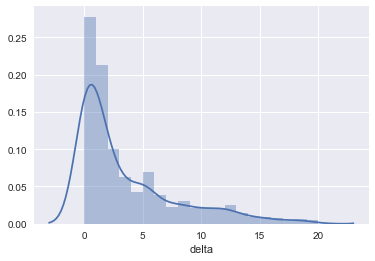

In [30]:
sns.distplot(df_s['delta'])

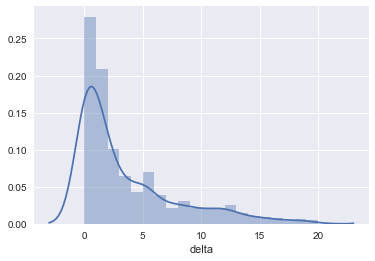

In [32]:
df_s_e = df_s.query('send_email == 1')
sns.distplot(df_s_e['delta'])

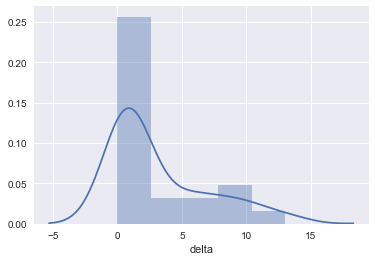

In [33]:
df_s_c = df_s.query('send_email == 0')
sns.distplot(df_s_c['delta'])

In [38]:
n1 = df.loc[df['send_email']==0].shape[0]
obs_1 = df.loc[(df['send_email']==0) & (df['submit_apps']==1)]
obs_v1 = obs_1.shape[0]
mean_v1 = np.mean(obs_1['delta'])

n2 = df.loc[df['send_email']==1].shape[0]
obs_2 = df.loc[(df['send_email']==1) & (df['submit_apps']==1)]
obs_v2 = obs_2.shape[0]
mean_v2 = np.mean(obs_2['delta'])

print("{0} students received reminder emails, {1} of them submit their apps ({2}), avg. time to submit an application is {3} days.".format(n2,obs_v2,obs_v2/n2,mean_v2))
print("{0} students don't received reminder emails, {1} of them submit their apps ({2}), avg. time to submit an application is {3} days.".format(n1,obs_v1,obs_v1/n1,mean_v1))

12389 students received reminder emails, 914 of them submit their apps (0.07377512309306643), avg. time to submit an application is 3.5196936542669586 days.
541 students don't received reminder emails, 24 of them submit their apps (0.04436229205175601), avg. time to submit an application is 3.1666666666666665 days.


In [39]:
df_submitted = df.query('submit_apps == 1')
m_s = np.mean(df_submitted['delta'])
sd_s = np.var(df_submitted['delta'])
print("Pool mean: {0}; Pool variance: {1}".format(m_s,sd_s))

Pool mean: 3.5106609808102345; Pool variance: 18.63581384881862


In [41]:
m1_s = mean_v1
m2_s = mean_v2
sd1_s = np.var(obs_1['delta'])
sd2_s = np.var(obs_2['delta'])
print("Students received emails: mean is {0} and variance is {1}".format(m2_s,sd2_s))
print("Students don't receive emails: mean is {0} and variance is {1}".format(m1_s,sd1_s))

Students received emails: mean is 3.5196936542669586 and variance is 18.755082619500303
Students don't receive emails: mean is 3.1666666666666665 and variance is 13.972222222222223


In [42]:
# 95% CI:
g1_lower = m1_s-1.96*np.sqrt(sd1_s/n1)
g1_upper = m1_s+1.96*np.sqrt(sd1_s/n1)
g2_lower = m2_s-1.96*np.sqrt(sd2_s/n2)
g2_upper = m2_s+1.96*np.sqrt(sd2_s/n2)
print("for student received emails, 95% of CI conversion rate: [{0},{1}]".format(g2_lower,g2_upper))
print("for student don't receive emails, 95% of CI conversion rate: [{0},{1}]".format(g1_lower,g1_upper))

for student received emails, 95% of CI conversion rate: [3.443433542805363,3.595953765728554]
for student don't receive emails, 95% of CI conversion rate: [2.851681443033869,3.481651890299464]


In [ ]:
# draw a Beta distribution
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1)

for i in range(1,3):
    a = 2
    b = i
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
    
    print (a,b)
    x = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
    ax.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='beta pdf')

In [ ]:
# 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

mu = m
variance = sd
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

In [ ]:
(8+50+68)/3